# Causal Discovery in Gene Expression Data

In the following, we will explore the [Sachs dataset](https://www.science.org/doi/abs/10.1126/science.1105809) and aim to discover the most probable causal edges via causal discovery. **Your task is to:**
1. (~5 min) Explore the data set a bit, plot the ground truth graph
2. (~15 min) Get familiar with the **Causal Discovery Toolbox** package and compare a few CD algorithms: the [PC algorithm](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html#pc), [LiNGAM](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html#lingam), [GES](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html#ges) (a score-based method), and [CAM](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/causality.html#cam) (a likelihood-based method allowing for non-linear functions). For each of them:
    1. Apply them to the Sachs dataset
    2. Plot the estimated graph and compare it to the ground truth (what are your key observations?)
    3. Compute SHD to the ground truth graph (see below)
3. Select the method of your choice and discover the most likely causal graph; i.e.
    1. Draw multiple random subsets of the data (e.g., <code>D1, D2, D3, ..., D10</code>), each containing a fraction of the original data (e.g., 60%). You can get a random subset of your data by running, e.g.<code>data.sample(n=4000, replace=False)</code>.
    2. Apply your algorithm of choice to each data set <code>Di</code> and obtain an estimated graph <code>Gi</code>.
    3. Determine the most likely causal graph by keeping those edges that occur in at least XX% of all estimated graphs (you can use the method <code>most_plausible_graph</code> below). It is up to you to determine the percentage, report the number and write down your thought process.
4. Plot the obtained graph and determine its SHD. Additional to SHD, check how many ground truth edges (you can use the function <code>correct_ground_truth_edges</code>) you recovered and how many edges your graph contained in total. Report your results. (Bonus) Can you come up with another meaningful measure?

**Note (Step 2):** If there is some time left, you can try other algorithms or independence tests. However, many of them simply take too long to terminate for this tutorial (e.g., using HSIC with PC). Focus on methods that are fast (terminate ~1 minute; max 2).

**Note (Step 3):** You can also consider discretizing the data before applying your method (if you use GES or PC)---as the original authors did. It would allow you to explore discrete CI tests and might provide a runtime advantage.

## Below, you will find sample code on:
* How to load the data
* Plot the ground truth graph
* Apply the PC algorithm and plot its estimated graph
* Evaluate the [structural Hamming distance (SHD)](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/metrics.html?highlight=shd#cdt.metrics.SHD) between the estimated and the ground truth graph
* Merge graphs based on a certain threshold to obtain those edges that occur frequently

The **SHD** is often used to evaluate how similar two graphs are. In the causal discovery context, it measures the number of edge insertions, deletions, or flips necessary to transform the estimated graph into the ground truth graph. Thus, **the smaller the SHD, the better**.

## Important documentations:
- We can apply causal discovery algorithms and independence tests implemented in the **Causal Discovery Toolbox** ([Documentation](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/index.html))
- The package **NetworkX** is used to represent graphs ([Documentation](https://networkx.org))

## Loading the data and some required packages

In [1]:
import cdt
import networkx as nx
import matplotlib.pyplot as plt
from cdt.causality.graph import PC
from cdt.causality.graph import LiNGAM
from cdt.causality.graph import CAM
from cdt.causality.graph import GES
from cdt.metrics import SHD

data, gt_graph = cdt.data.load_dataset('sachs')

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


## Plotting graphs

In [2]:
import io
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def plot_graph(graph):
    # convert to pydot format
    pyd = nx.nx_pydot.to_pydot(graph)
    # plot graph
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img, aspect='auto')
    plt.show()

## Merging multiple graphs

This function will be helpful for Step 3 in the project. Use it to determine the most likely graph for which each edge occurs in multiple estimated graphs (fraction depends on the threshold).

In [3]:
# expects array of graphs and a threshold, e.g. 
# graphs = [g1]
# graphs.append(g2)
# ...
def most_plausible_graph(graphs, thr=0.8):
    # generates union of edges of all graphs
    union_graph = nx.compose_all(graphs)
    # edges to remove
    to_remove = []
    # iterate over edges and delete them if they do not occur frequently enough
    for u,v in union_graph.edges():
        occurance_uv = 0
        for g in graphs:
            if g.has_edge(u,v):
                occurance_uv = occurance_uv + 1
        if occurance_uv / len(graphs) < thr:
            to_remove.append((u,v))
    for u,v in to_remove:
        union_graph.remove_edge(u,v)
    return union_graph

## Counting correct edges

In [3]:
def correct_ground_truth_edges(gt_graph, est_graph):
    correct_edges = 0
    for u,v in est_graph.edges():
        if gt_graph.has_edge(u,v):
            correct_edges = correct_edges + 1
    return correct_edges

## Exploring the data and plotting the ground truth graph

These are only minimal examples of how to inspect the data. Feel free to do more.

   praf  pmek   plcg   PIP2   PIP3  p44/42  pakts473    PKA    PKC   P38  pjnk
0  26.4  13.2   8.82  18.30  58.80    6.61      17.0  414.0  17.00  44.9  40.0
1  35.9  16.5  12.30  16.80   8.13   18.60      32.5  352.0   3.37  16.5  61.5
2  59.4  44.1  14.60  10.20  13.00   14.90      32.5  403.0  11.40  31.9  19.5
3  73.0  82.8  23.10  13.50   1.29    5.83      11.8  528.0  13.70  28.6  23.1
4  33.7  19.8   5.19   9.73  24.80   21.10      46.1  305.0   4.66  25.7  81.3
              praf         pmek         plcg         PIP2         PIP3  \
count  7466.000000  7466.000000  7466.000000  7466.000000  7466.000000   
mean    124.071930   145.380962    54.853643   151.120738    27.034962   
std     247.528092   377.056214   173.859778   299.347505    43.048160   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%      30.800000    16.500000     9.410000    18.300000     9.560000   
50%      53.800000    26.700000    16.500000    52.800000    17.800000   
75%     

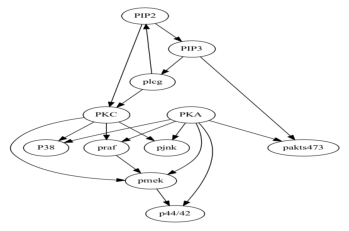

In [4]:
print(data.head())
print(data.describe())
plot_graph(gt_graph)

## Apply Graph Lasso

Before we apply a causal discovery method, we take a look at the output of [Graph Lasso](https://fentechsolutions.github.io/CausalDiscoveryToolbox/html/independence.html?highlight=graph%20lasso#glasso) to gain some awareness w.r.t. the difficulty of the problem.

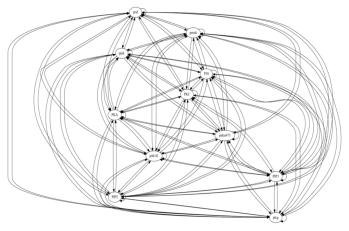

In [6]:
glasso = cdt.independence.graph.Glasso()
glasso_skeleton = glasso.predict(data)
plot_graph(glasso_skeleton)

## Appy the PC algorithm

Here we run the PC algorithm, plot its estimated graph and compare its SHD to the graph estimated with Graph Lasso.

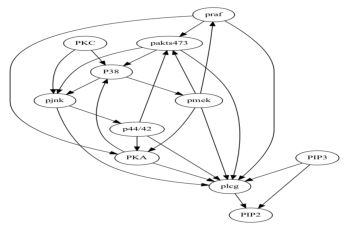

60.5
27.0


In [7]:
# Run PC
pc_algo = PC(CItest='gaussian')
est_graph_pc = pc_algo.predict(data)
# Plot estimated graph
plot_graph(est_graph_pc)

# Compute SHD for GLasso
print(SHD(gt_graph, glasso_skeleton, double_for_anticausal=False))
# Compute SHD for PC
print(SHD(gt_graph, est_graph_pc, double_for_anticausal=False))

# You can take it from here :)